In [1]:
import pandas as pd
from sklearn.utils import check_random_state
from sklearn.preprocessing import StandardScaler
import numpy as np


In [2]:
SEED = 2010
RANDOM = check_random_state(SEED)


In [3]:
file1 = "../EXP/EXP_data/expression.csv"
exp1 = pd.read_csv(file1, sep="\t", index_col=0, header=0).T
scaler = StandardScaler()
scaled_exp1 = scaler.fit_transform(exp1.T)


In [6]:
gene_correlations = np.corrcoef(scaled_exp1)


In [7]:
gene_ids = exp1.columns.values
gene_idx = list(range(len(gene_ids)))


In [8]:
mask = gene_correlations > 0.9
coexp = {}
for i, id in enumerate(gene_ids):
    coexp[id] = np.setdiff1d(gene_ids[mask[i]], id)


In [9]:
n_ids_w_neighbors = 0

for val in coexp.values():
    n_ids_w_neighbors += 1 if len(val) > 0 else 0


In [10]:
print(
    f"percent that have neighbor: {(n_ids_w_neighbors / gene_correlations.shape[0] * 100):.4f}"
)


percent that have neighbor: 43.3817


In [8]:
"AT3G04935" in coexp["AT3G04935"]


False

In [9]:
with open("../gene2vec_data/coexp.txt", "w") as f:
    for key, val in coexp.items():
        if len(val) > 0:
            for gene in val:
                pair = key + " " + gene + "\n"
                f.write(pair)


In [13]:
with open("../gene2vec_data/coexp.txt", "r") as d:
    i = 0
    for line in d:
        i += 1

    print(i)


113709402


*Problem: only half of the genes have atleast 1 coexpression neighbor*

In [4]:
col_names = [
    "locus_name",
    "TAIR_accession",
    "object_name",
    "relationship_type",
    "GO_term",
    "GO_ID",
    "TAIR_Keyword_ID",
    "Aspect",
    "GOslim_term",
    "Evidence_code",
    "Evidence_description",
    "Evidence_with",
    "Reference",
    "Annotator",
    "Date_annotated",
]


In [25]:
goslim = pd.read_csv("../GO/ATH_GO_GOSLIM.txt", sep="\t", skiprows=5, names=col_names)


In [32]:
print(type(gene_ids), type(goslim.locus_name))


<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [47]:
exp_go_intersection = np.isin(goslim.locus_name, gene_ids)


In [44]:
gene_ids_in_goslim = gene_ids[exp_go_intersection]


In [50]:
len(goslim[exp_go_intersection].locus_name.unique())


28802

In [51]:
superficial = ["biological_process", "cellular_component", "molecular_function"]


In [57]:
is_superficial = np.isin(goslim.GO_term, superficial)


In [66]:
not_superficial_exp_go = exp_go_intersection & (~is_superficial)


In [70]:
len(goslim[not_superficial_exp_go].locus_name.unique())


26645

### Dimension reduction


In [5]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


In [6]:
row_data = pd.read_csv("../EXP/EXP_data/rowdata.csv", sep="\t", header=0, index_col=0)


In [7]:
import glob


In [8]:
idx_file = []
for file in glob.glob("../gene2vec_data/*.txt"):
    iter = file.split("_")[-1]
    iter = iter.split(".")[0]
    idx_file.append((int(iter), file))


In [9]:
files_sorted = sorted(idx_file, key=lambda x: x[0])


In [10]:
with open(files_sorted[-1][1], "r") as f:
    emb_dict = {}
    for line in f:
        key, val = line.strip().split("\t")
        val = val.split(" ")
        emb_dict[key] = val

df_emb = pd.DataFrame.from_dict(emb_dict, orient="index")


In [11]:
row_data.index[0]


'AT1G01010'

In [12]:
labels = row_data.loc[df_emb.index].locustype.values


In [13]:
row_data.locustype.value_counts()


protein_coding                  27655
transposable_element_gene        3901
long_noncoding_rna               2444
antisense_long_noncoding_rna     1037
pseudogene                        927
pre_trna                          689
small_nucleolar_rna               287
other_rna                         221
small_nuclear_rna                  80
antisense_rna                      78
ribosomal_rna                      15
Name: locustype, dtype: int64

In [16]:
num_labels = [1 if label == "protein_coding" else 0 for label in labels]


In [14]:
labeltoi = {
    key: val for val, key in zip(list(range(len(set(new_labels)))), set(new_labels))
}


NameError: name 'new_labels' is not defined

In [178]:
non_coding = [
    "long_noncoding_rna",
    np.NAN,
    "other_rna",
    "pseudogene",
    "antisense_long_noncoding_rna",
    "transpos",
]

bins = {
    "Coding": ["protein_coding", "transposable_element_gene"],
    "Non-coding": [
        "long_noncoding_rna",
        "pre_trna",
        "antisense_rna",
        "other_rna",
        "pseudogene",
        "small_nucleolar_rna",
        "small_nuclear_rna",
        "ribosomal_rna",
        "antisense_long_noncoding_rna",
    ],
    "Missing": ["nan"],
}
coding = ["protein_coding", "transposable_element_gene"]

for key, val in labeltoi.items():
    if key in coding:
        labeltoi[key] = 2
    else:
        labeltoi[key] = 1

labeltoi[np.NAN] = 0


In [215]:
bins = {
    "LOC non-coding genes": ["long_noncoding_rna", "antisense_long_noncoding_rna"],
    "microRNA": [
        "other_rna",
        "pre_trna",
        "pseudogene",
    ],  # Adjust as needed based on actual labels
    "small nucleolar RNA (snoRNA)": ["small_nucleolar_rna"],
    "undercharacterized ORFs": [
        "protein_coding",
        "transposable_element_gene",
        "ribosomal_rna",
        "small_nuclear_rna",
        "antisense_rna",
    ],
}

binned_labels = {key: [] for key in bins.keys()}

for label in list(labeltoi.keys()):
    for category, category_labels in bins.items():
        if label in category_labels:
            binned_labels[category].append(label)

# Print the binned labels
for category, items in binned_labels.items():
    print(f"{category}: {items}")


LOC non-coding genes: ['long_noncoding_rna', 'antisense_long_noncoding_rna']
microRNA: ['pre_trna', 'other_rna', 'pseudogene']
small nucleolar RNA (snoRNA): ['small_nucleolar_rna']
undercharacterized ORFs: ['protein_coding', 'transposable_element_gene', 'antisense_rna', 'small_nuclear_rna', 'ribosomal_rna']


In [217]:
new_labels = []

for label in labels:
    if label in bins["LOC non-coding genes"]:
        new_labels += ["LOC non-coding genes"]
    elif label in bins["small nucleolar RNA (snoRNA)"]:
        new_labels += ["small nucleolar RNA (snoRNA)"]
    else:
        new_labels += ["undercharacterized ORFs"]


In [222]:
num_labels = [labeltoi[x] for x in new_labels]


In [110]:
len(set(labels))


12

In [111]:
len(num_labels)


16197

In [18]:
pca = PCA(n_components=50)
pca_emb = pca.fit_transform(df_emb)
pca_tsne = TSNE(n_components=2, init="random", perplexity=3)
pca_tsne_emb = pca_tsne.fit_transform(pca_emb)


In [19]:
pca_tsne_emb.shape


(16197, 2)

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(
    pca_tsne_emb[:, 0], pca_tsne_emb[:, 1], s=10, c=num_labels, label=num_labels
)
plt.xlabel("TSNE_1")
plt.ylabel("TSNE_2")
# plt.savefig("tsne_protcod.png", dpi=350, transparent=False)


ValueError: Image size of 204593x481 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 576x576 with 1 Axes>

In [21]:
tsne = TSNE(n_components=2, init="random", perplexity=3)


In [22]:
X_emb = tsne.fit_transform(df_emb)


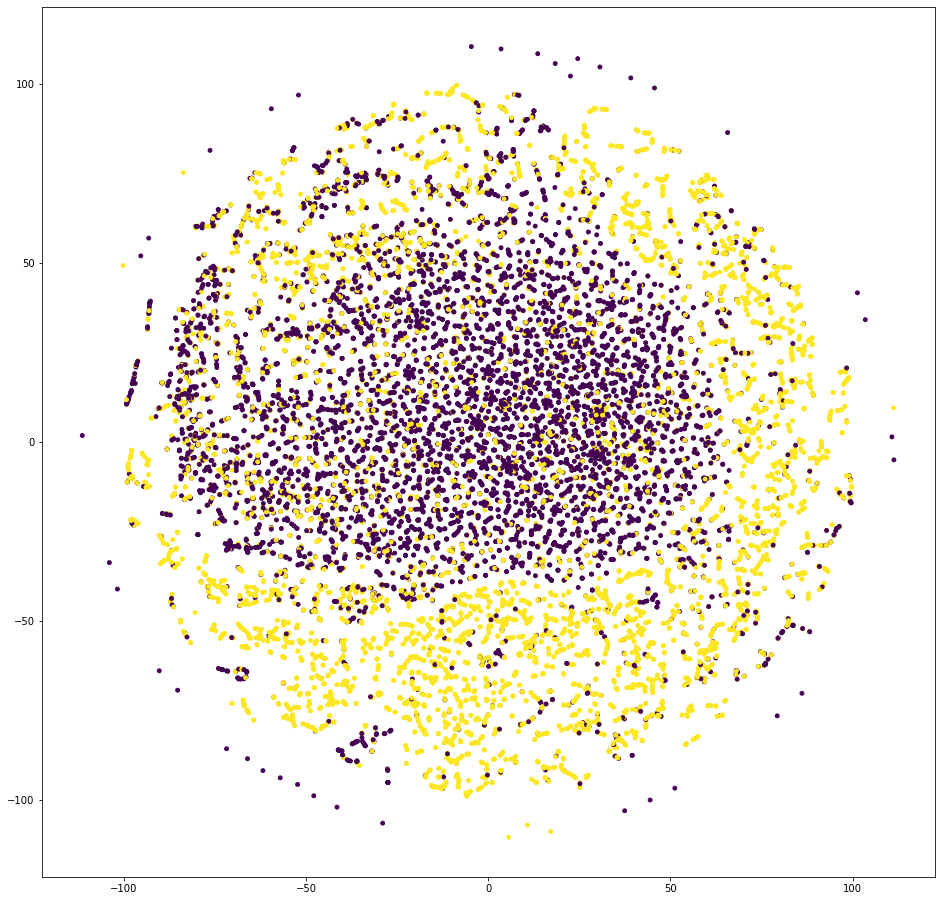

In [24]:
plt.figure(figsize=(16, 16))
plt.scatter(X_emb[:, 0], X_emb[:, 1], s=15, c=num_labels, label=num_labels)


In [133]:
itolabels = {val: str(key) for key, val in labeltoi.items()}


array(['transposable_element_gene', 'protein_coding', 'pseudogene', ...,
       'protein_coding', 'protein_coding', 'protein_coding'], dtype=object)

In [29]:
from matplotlib.colors import ListedColormap

colors = ["#1f77b4", "#ff7f0e"]  # Blue  # Orange

# Create a ListedColormap
cmap = ListedColormap(colors)


In [225]:
colors = ["#000000", "#FF5733", "#2E8B57"]  # Black  # Bright Red-Orange  # Sea Green
# Black  # Red  # Green
cmap = ListedColormap(colors)


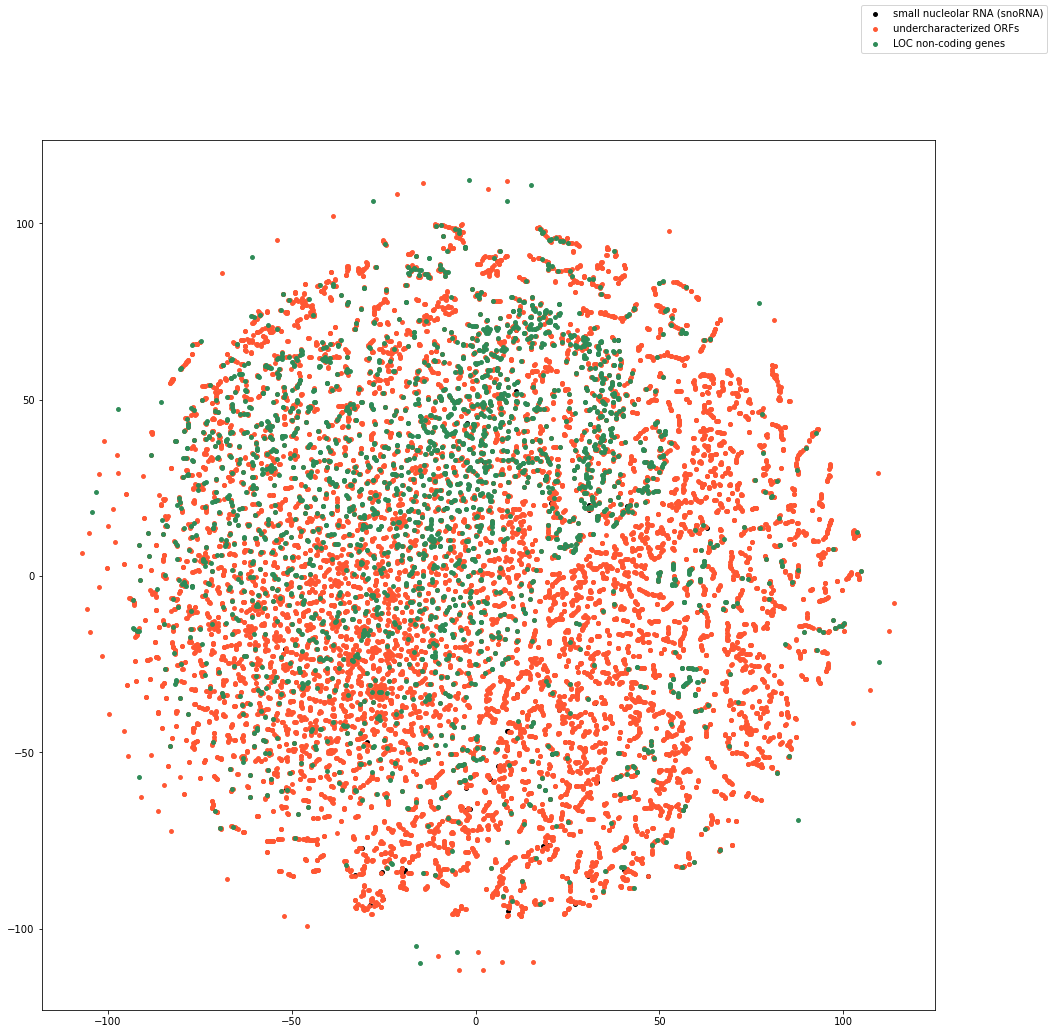

In [226]:
fig, ax = plt.subplots(figsize=(16, 16))
scatter_x = X_emb[:, 0]
scatter_y = X_emb[:, 1]
group = num_labels
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(scatter_x[i], scatter_y[i], label=g, s=15, color=cmap(g))

handles, labs = ax.get_legend_handles_labels()
labs = list(labeltoi.keys())

fig.legend(handles, labs, loc="upper right")


In [229]:
Large = [
    "protein_coding",
    "transposable_element_gene",
    "long_noncoding_rna",
    "antisense_long_noncoding_rna",
]
Small = [
    "pseudogene",
    "pre_trna",
    "small_nucleolar_rna",
    "other_rna",
    "small_nuclear_rna",
    "antisense_rna",
    "ribosomal_rna",
]


In [236]:
new_labels = ["other" if label in Large else label for label in labels]


In [249]:
labtoi = {key: val for key, val in zip(set(new_labels), list(range(9)))}


In [252]:
num_labels = [labtoi[x] for x in new_labels]


In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter_x = X_emb[:, 0]
scatter_y = X_emb[:, 1]
group = num_labels
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(scatter_x[i], scatter_y[i], label=g, s=15)

handles, labs = ax.get_legend_handles_labels()

fig.legend(handles, labs, loc="upper right")


NameError: name 'plt' is not defined

In [144]:
list(labeltoi.keys())


[nan,
 'protein_coding',
 'transposable_element_gene',
 'long_noncoding_rna',
 'pre_trna',
 'antisense_rna',
 'other_rna',
 'pseudogene',
 'small_nucleolar_rna',
 'small_nuclear_rna',
 'ribosomal_rna',
 'antisense_long_noncoding_rna']